In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
%%time
df_train = pd.read_csv('clean/train_v2.csv',converters={"fullVisitorId": str})

Wall time: 8.52 s


In [3]:
%%time
df_test = pd.read_csv('clean/test_v2.csv',converters={"fullVisitorId": str})

Wall time: 2.07 s


In [4]:
df_train["date"] = pd.to_datetime(df_train["date"], format="%Y-%m-%d") # seting the column as pandas datetime
df_test["date"] = pd.to_datetime(df_test["date"], format="%Y-%m-%d") # seting the column as pandas datetime

## Exploratory Analysis

### 1. How many of the visits will result in transaction (buying)

In [5]:
print('There is only {}% completed transaction in dataset.'\
      .format(round(len(df_train[df_train['totals.totalTransactionRevenue'] > 0]) / df_train.shape[0] * 100, 2)))

There is only 1.08% completed transaction in dataset.


- Only 1% of the visits convert into transaction (buying)

### 2. A deeper look on visit frequency and number of transaction (buying)

In [6]:
# Aggregate by visitor ID to get frequency of visit
visitFreq_agg = df_train.groupby('fullVisitorId').agg(frequency = ('fullVisitorId', 'count') , 
                                                      transactions = ('totals.transactions', 'sum'))

visitFreq_agg['visitRange'] = pd.cut(visitFreq_agg['frequency'], [-1, 1, 2, 3, 6, 10, 20, 40, 80, 500],
                                     labels = ['1', '2', '3', '4-6', '7-10', '11-20', '21-40', '41-80', '81-500'])

visitFreq_agg = visitFreq_agg.groupby('visitRange').agg(visit_frequency = ('frequency','count'),
                                                        no_of_transactions =('transactions','sum'))
visitFreq_agg['frequency_%'] = (visitFreq_agg['visit_frequency']/sum(visitFreq_agg['visit_frequency'])).map("{:.2%}".format)
visitFreq_agg['transactions_%'] = (visitFreq_agg['no_of_transactions']/sum(visitFreq_agg['no_of_transactions'])).map("{:.2%}".format)


visitFreq_agg[['visit_frequency','frequency_%','no_of_transactions','transactions_%']]

,visit_frequency,frequency_%,no_of_transactions,transactions_%
visitRange,,,,
1,1138049,85.97%,5091,26.34%
2,115694,8.74%,3853,19.93%
3,34104,2.58%,2590,13.40%
4-6,26227,1.98%,3984,20.61%
7-10,6392,0.48%,1924,9.95%
11-20,2505,0.19%,1162,6.01%
21-40,571,0.04%,549,2.84%
41-80,135,0.01%,73,0.38%
81-500,53,0.00%,104,0.54%


- Most visitors (85.97%) only visit the website once
- For the visitors that visit the site for 4 - 6 times, they have the highest probability of buy something, \
although they only account for 1.98% of total visitors, they contribute 20.61% of the total transactions (buying)

In [7]:
purchaseFreq_agg = df_train.groupby('fullVisitorId').agg(frequency = ('totals.transactions', 'sum'))
purchaseFreq_agg['purchaseRange'] = pd.cut(purchaseFreq_agg['frequency'], [-1, 0, 1, 2, 3, 6, 15, 40],
                                        labels = ['0', '1', '2', '3', '4-6', '7-15', '16-40'])
purchaseFreq_agg = purchaseFreq_agg.groupby('purchaseRange').agg('count')
purchaseFreq_agg

,frequency
purchaseRange,
0,1307559
1,14336
2,1293
3,304
4-6,177
7-15,52
16-40,9


- For the visitor that buying thing most of them only buy one thing 

### The distribution for visit and purchase frequency 
(after removing visit freq : 1 and purchaseRange : 0 & 1)

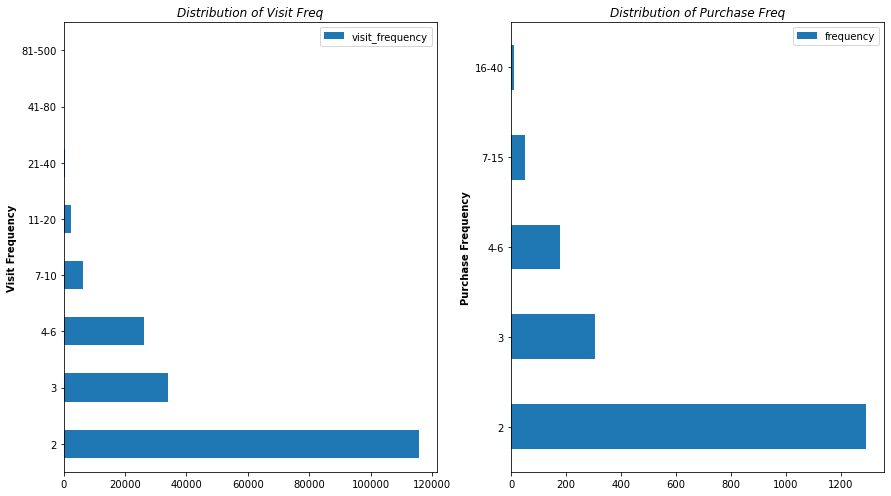

In [9]:
fig,axes = plt.subplots(1,2,figsize = (14.70, 8.27))
visitFreq_agg[1:][['visit_frequency']].plot.barh(ax = axes[0])

axes[0].set_title('Distribution of Visit Freq', fontsize = 12, style = 'italic')
axes[0].set_ylabel('Visit Frequency', fontsize = 10, weight = 'bold');

purchaseFreq_agg[2:].plot.barh(ax = axes[1])

axes[1].set_title('Distribution of Purchase Freq', fontsize = 12, style = 'italic')
axes[1].set_ylabel('Purchase Frequency', fontsize = 10, weight = 'bold');


### 3. Do the number of visits and purchase (transaction) effected by seasonality?


In [10]:
GData = df_train.groupby('date').agg(visitFreq = ('fullVisitorId', 'count'),
                                     newVisit = ('totals.newVisits', 'sum'),
                                     transaction = ('totals.transactions', 'sum'))

GData = GData.reset_index()

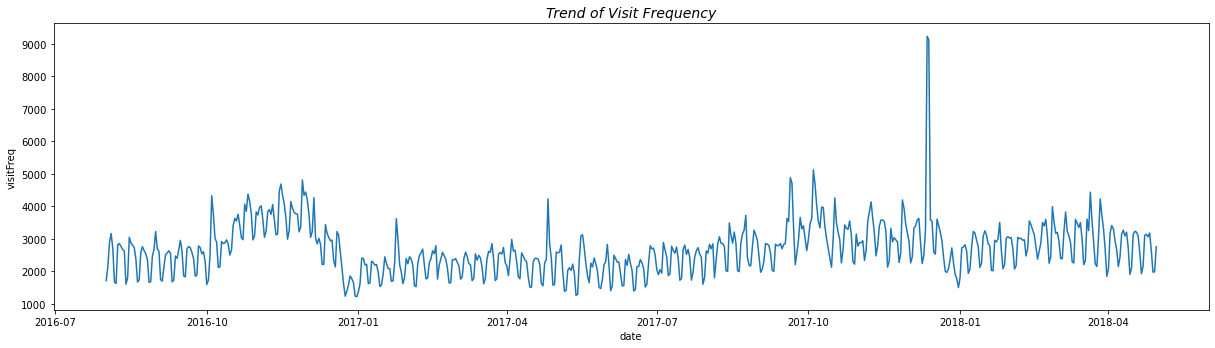

In [11]:
## Graph for visit frequency

fig, ax =  plt.subplots(1, 1, figsize = (20.70, 5.27))
sns.lineplot(x="date", y="visitFreq", data=GData)

ax.set_title('Trend of Visit Frequency', fontsize = 14, style = 'italic');

In [12]:
GData.nlargest(10,['visitFreq'])

,date,visitFreq,newVisit,transaction
498,2017-12-12,9234,8159,30
499,2017-12-13,9131,7400,48
429,2017-10-04,5122,3822,35
415,2017-09-20,4880,3846,33
119,2016-11-28,4807,3834,73
416,2017-09-21,4715,3637,33
106,2016-11-15,4685,3837,33
430,2017-10-05,4679,3487,25
105,2016-11-14,4466,3558,39
121,2016-11-30,4435,3498,58


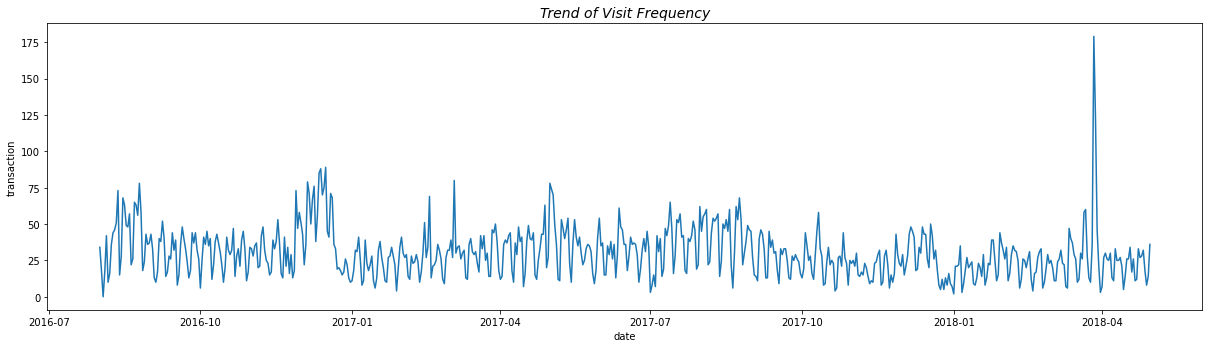

In [13]:
## Graph for sum of transaction (buying)

fig, ax =  plt.subplots(1, 1, figsize = (20.70, 5.27))
sns.lineplot(x="date", y="transaction", data=GData)

ax.set_title('Trend of Visit Frequency', fontsize = 14, style = 'italic'); 

In [14]:
GData.nlargest(10,['transaction'])

,date,visitFreq,newVisit,transaction
603,2018-03-27,4227,3057,179
604,2018-03-28,3724,2576,123
137,2016-12-16,2956,2106,89
134,2016-12-13,3166,2256,88
133,2016-12-12,3433,2464,85
215,2017-03-04,1753,1396,80
126,2016-12-05,4265,3217,79
24,2016-08-25,2539,1921,78
273,2017-05-01,2588,1906,78
130,2016-12-09,2830,1967,76


### Noted something weird? Let compared them in s single graph

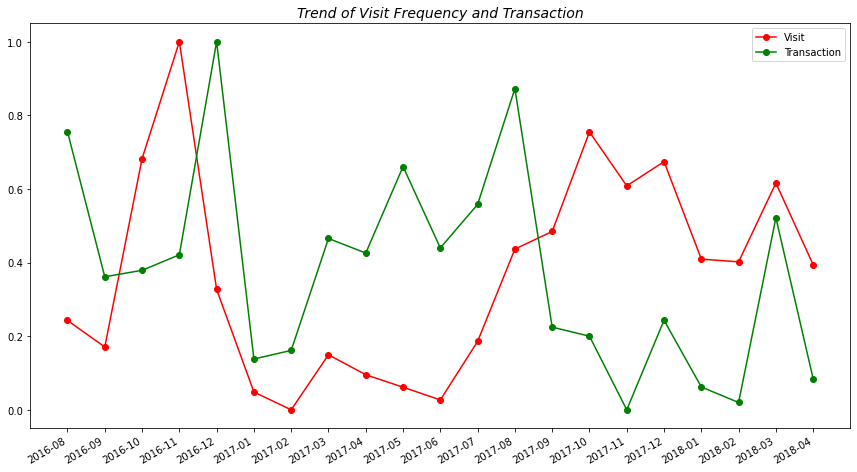

In [18]:
df_train['yearMonth'] = df_train['date'].dt.to_period('M')

monthly_visit = df_train.groupby('yearMonth').agg(visitFreq = ('fullVisitorId', 'count'),
                                                  transaction = ('totals.transactions', 'sum'))

monthly_visit.reset_index(inplace = True)
monthly_visit['yearMonth'] = monthly_visit['yearMonth'].astype(str)

min_max_scaler = MinMaxScaler()
monthly_visit['visitFreq'] = min_max_scaler.fit_transform(monthly_visit[['visitFreq']])
monthly_visit['transaction'] = min_max_scaler.fit_transform(monthly_visit[['transaction']])

fig, ax =  plt.subplots(1, 1, figsize = (14.70, 8.27))

ax.plot_date(monthly_visit['yearMonth'], monthly_visit["visitFreq"], color="red", label="Visit", linestyle="-")
ax.plot_date(monthly_visit['yearMonth'], monthly_visit["transaction"], color="green", label="Transaction", linestyle="-")
ax.legend()
ax.set_title('Trend of Visit Frequency and Transaction', fontsize = 14, style = 'italic'); 
plt.gcf().autofmt_xdate();

### Yes, bingo, the period with most visit != the period with highest selling

### 3. When Gstore gain most of the profit

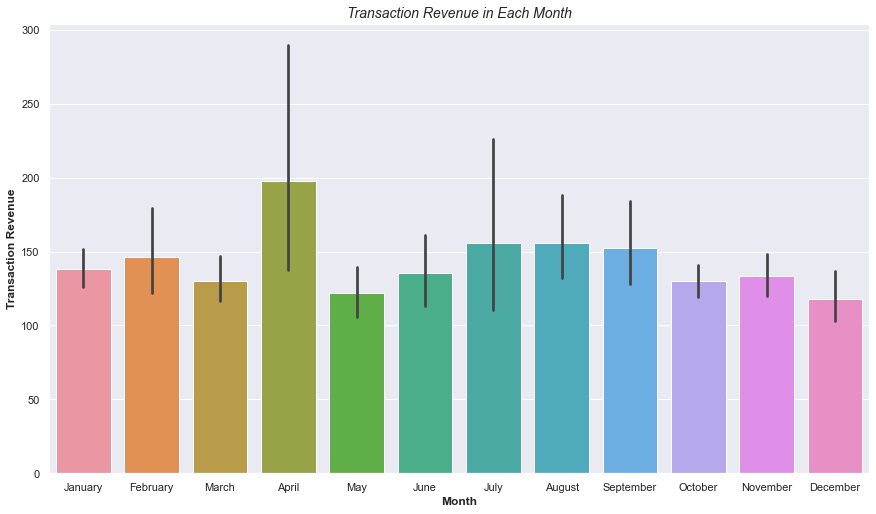

In [20]:
# Define order of month for better visualization
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(14.70, 8.27))

# Set sns style
sns.set(style="darkgrid")

# Removing the rainbow colors and use only ONE color
base_color = sns.color_palette()[0]

sns.barplot(data = df_train,
            x = 'visit_month',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6),
            order = month_order)
plt.title("Transaction Revenue in Each Month", fontsize = 14, style = 'italic')
plt.xlabel("Month", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

- Revenue peak on April

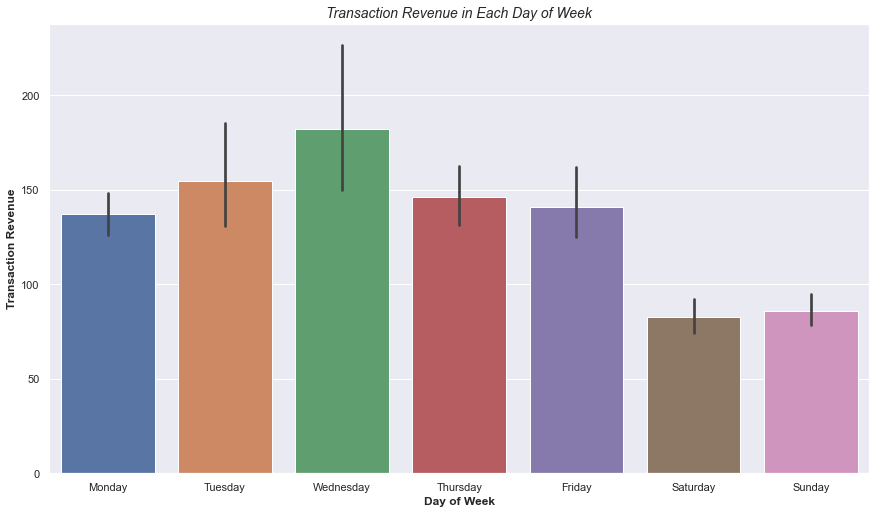

In [21]:
# Define order of day for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14.70, 8.27))
sns.barplot(data = df_train,
            x = 'visit_weekday',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6),
            order = day_order)
plt.title("Transaction Revenue in Each Day of Week", fontsize = 14, style = 'italic')
plt.xlabel("Day of Week", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

#### Sales concentrated on Weekday? Interesting

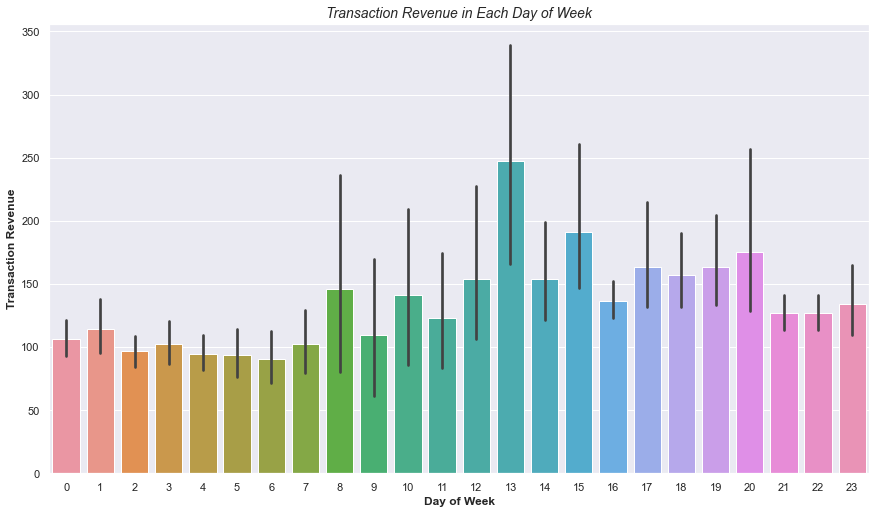

In [22]:
plt.figure(figsize=(14.70, 8.27))
sns.barplot(data = df_train,
            x = 'visit_hour',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6))
plt.title("Transaction Revenue in Each Day of Week", fontsize = 14, style = 'italic')
plt.xlabel("Day of Week", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

#### Most revenue gain by visit in 13:00 (1:00pm), ok some story appeared

### 4. What device visitor use to visit Gstore 

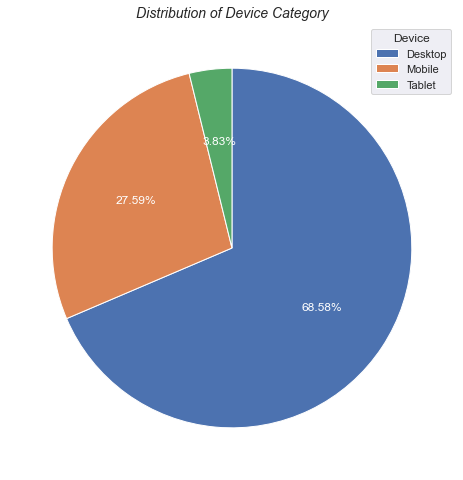

In [25]:
device = df_train['device.deviceCategory'].value_counts()

plt.figure(figsize=[14.70, 8.27])
plt.pie(device, labels = device.index, startangle = 90, autopct= '%1.2f%%', counterclock = False, textprops={'color':'white'});
plt.legend(['Desktop', 'Mobile', 'Tablet'],
           title='Device', 
           loc='upper right')
plt.title('Distribution of Device Category', fontsize = 14,  style ='italic');

### 5. The location of the buyer

In [30]:
country = df_train.groupby('geoNetwork.country').agg(visitFreq = ('fullVisitorId', 'count'),
                                                     no_of_transactions =('totals.transactions','sum'))
country['visit_Freq%'] = (country['visitFreq']/sum(country['visitFreq'])).map("{:.2%}".format)
country['trans_Freq%'] = (country['no_of_transactions']/sum(country['no_of_transactions'])).map("{:.2%}".format)

country = country[['visitFreq','visit_Freq%','no_of_transactions','trans_Freq%']]


country.sort_values(by=['visitFreq'],ascending = False).head(10)

,visitFreq,visit_Freq%,no_of_transactions,trans_Freq%
geoNetwork.country,,,,
United States,717217,42.05%,18349,94.96%
India,105317,6.17%,18,0.09%
United Kingdom,73341,4.30%,28,0.14%
Canada,51057,2.99%,327,1.69%
Germany,38516,2.26%,12,0.06%
Japan,36637,2.15%,23,0.12%
Brazil,35432,2.08%,21,0.11%
Vietnam,34869,2.04%,0,0.00%
France,32289,1.89%,16,0.08%


#### Visualize the result

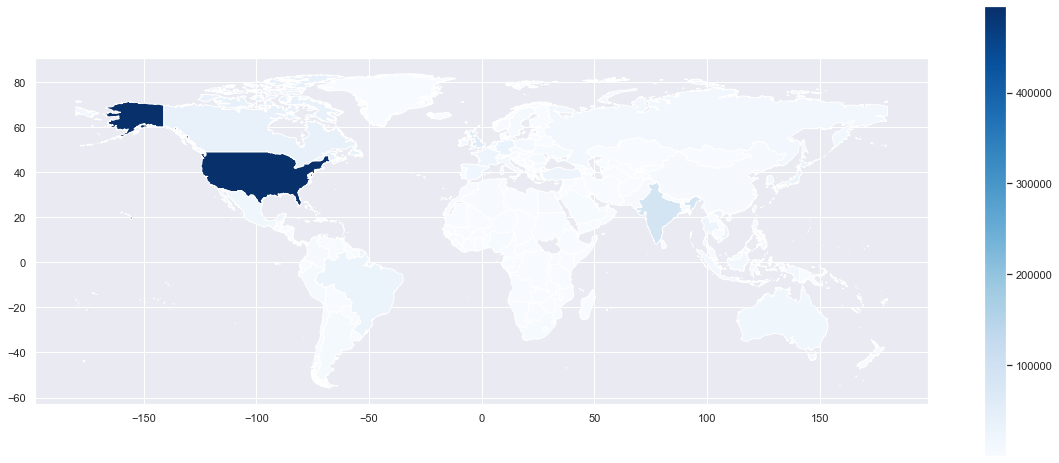

In [28]:
# https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries-2/
# Import geolocation shape file

import geopandas as gpd
import pycountry

world = gpd.read_file('map/ne_50m_admin_0_countries.shp')
#world

country_visitor = df_train.groupby(['geoNetwork.country', 'fullVisitorId']).size().reset_index()
country_visitor = country_visitor.groupby(['geoNetwork.country']).agg(count = ('fullVisitorId', 'count')).reset_index()
country_visitor.sort_values(by = 'count', ascending = False)

input_countries = country_visitor['geoNetwork.country']
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]
country_visitor['countryCode'] = codes


# Manual fix unknowmn country code
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Antigua & Barbuda', 'countryCode'] = 'ATG' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Bolivia', 'countryCode'] = 'BOL' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Bosnia & Herzegovina', 'countryCode'] = 'BIH' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'British Virgin Islands', 'countryCode'] = 'VGB' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Brunei', 'countryCode'] = 'BRU' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Cape Verde']['countryCode'] == 'CPV' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Caribbean Netherlands', 'countryCode'] = 'BQ' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Congo - Brazzaville', 'countryCode'] = 'COG' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Congo - Kinshasa', 'countryCode'] = 'COD' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Côte d’Ivoire', 'countryCode'] = 'CIV' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Iran', 'countryCode'] = 'IRN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Kosovo', 'countryCode'] = 'KOS' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Laos', 'countryCode'] = 'LAO' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Macau', 'countryCode'] = 'MAC' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Macedonia (FYROM)', 'countryCode'] = 'MKD' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Micronesia', 'countryCode'] = 'FSM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Palestine', 'countryCode'] = 'PSE' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Russia', 'countryCode'] = 'RUS' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Sint Maarten', 'countryCode'] = 'SXM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'South Korea', 'countryCode'] = 'KOR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Barthélemy', 'countryCode'] = 'BLM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Helena', 'countryCode'] = 'SHN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Kitts & Nevis', 'countryCode'] = 'KNA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Lucia', 'countryCode'] = 'LCA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Martin', 'countryCode'] = 'MAF' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Pierre & Miquelon', 'countryCode'] = 'SPM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Vincent & Grenadines', 'countryCode'] = 'VCT' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Swaziland', 'countryCode'] = 'SWZ' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Syria', 'countryCode'] = 'SYR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'São Tomé & Príncipe', 'countryCode'] = 'STP' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Taiwan', 'countryCode'] = 'TWN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Tanzania', 'countryCode'] = 'TZA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Trinidad & Tobago', 'countryCode'] = 'TTO' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Turks & Caicos Islands', 'countryCode'] = 'TCA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'U.S. Virgin Islands', 'countryCode'] = 'VIR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Venezuela', 'countryCode'] = 'VEN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Vietnam', 'countryCode'] = 'VNM'

merged = world.merge(country_visitor, left_on='ADM0_A3', right_on='countryCode')

# Plot using geopandas
colors = 9
cmap = 'Blues'
figsize=(20, 8.27)
merged.plot(column='count', cmap=cmap, figsize=figsize, k=colors, legend=True);

#### Most of the visits comes from united state, and nearly 95% of the transaction (buying) is come from United State

#### Now more question, which part of the United State?

In [31]:
city = df_train.groupby('geoNetwork.city').agg(visitFreq = ('fullVisitorId', 'count'),
                                                  no_of_transactions =('totals.transactions','sum'))
city['visit_Freq%'] = (city['visitFreq']/sum(country['visitFreq'])).map("{:.2%}".format)
city['trans_Freq%'] = (city['no_of_transactions']/sum(country['no_of_transactions'])).map("{:.2%}".format)

city = city[['visitFreq','visit_Freq%','no_of_transactions','trans_Freq%']]


city.sort_values(by=['visitFreq'],ascending = False).head(10)

### since geoNetwork.city have more NA compared to geoNetwork.country we divide the total visitfreq and transaction of a city
### with the sum of geoNetwork.country figure to get the idea of percentage.

,visitFreq,visit_Freq%,no_of_transactions,trans_Freq%
geoNetwork.city,,,,
Mountain View,74110,4.34%,2156,11.16%
New York,49460,2.90%,2527,13.08%
San Francisco,36960,2.17%,1180,6.11%
Sunnyvale,27923,1.64%,883,4.57%
London,23622,1.38%,19,0.10%
San Jose,20141,1.18%,393,2.03%
Los Angeles,17038,1.00%,491,2.54%
Chicago,15143,0.89%,697,3.61%
Bangkok,12468,0.73%,5,0.03%


#### Interesting info: Mountain View,Sunnyvale and San Jose is cities loacted inside silicon valley, together they account for 7.5% of the total visit and 18% of the total transaction (buying) of Gstore

## Info we get from exploratory analysis

- Most of the visitors (99%) only view and not buy
- Main customer of the sites come from United State, and the biggest group comes from silicon valley (where the company of google located)
- Most buying occured on weekdays and visit time around 1:00pm, possible is a lunch (rest time) of office
- The April and Oct-Dec is some hot season the sites been visited and buying occured \
(maybe due to gifts of easter day (April) and Chrismas (December)?)


### And last we have a view on what we groing to predicting in the part of Machine Learning
Since the target = log(1+sum(per user transactions)) we will look at the pdf of target to understand more about its distribution.

Transaction Revenue Min Value:  1.2
Transaction Revenue Mean Value:  142.81666954736957
Transaction Revenue Median Value:  52.79
Transaction Revenue Max Value:  47082.06


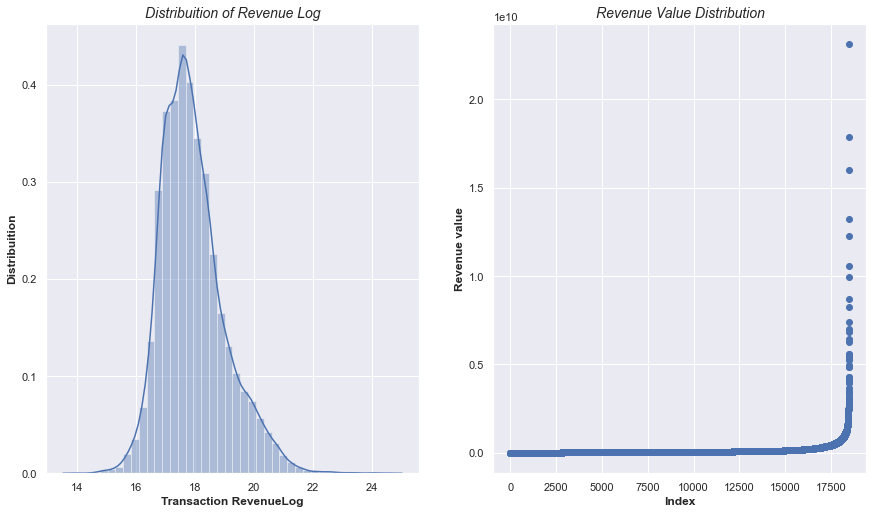

In [33]:
# Printing some statistics of our data
print("Transaction Revenue Min Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].min() / 10**6) # printing the min value
print("Transaction Revenue Mean Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].mean() / 10**6) # mean value
print("Transaction Revenue Median Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].median() / 10**6) # median value
print("Transaction Revenue Max Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].max() / 10**6) # the max value

# seting the figure size of our plots
plt.figure(figsize=(14.70, 8.27))

# Subplot allow us to plot more than one 
# in this case, will be create a subplot grid of 2 x 1
plt.subplot(1,2,1)
# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot(np.log(df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize = 12, weight = 'bold') #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize = 12, weight = 'bold') #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize = 14, style = 'italic') #seting the title and size of font

# setting the second plot of our grid of graphs
plt.subplot(1,2,2)
# ordering the total of users and seting the values of transactions to understanding 
plt.scatter(range(df_train.shape[0]), np.sort(df_train['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize = 12, weight = 'bold') # xlabel and size of words
plt.ylabel('Revenue value', fontsize = 12, weight = 'bold') # ylabel and size of words
plt.title("Revenue Value Distribution", fontsize = 14, style = 'italic'); # Setting Title and fontsize